<a href="https://colab.research.google.com/github/ZhexuanWang/AI-model-training/blob/master/GANTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Environment Setup
# Install TensorFlow (Colab usually has it preinstalled)
!pip install tensorflow==2.19.0
!pip install --upgrade numpy==2.0.1

In [2]:
# Step 2: Dataset preparation
import tensorflow as tf
import numpy as np

# Load CIFAR-10 as a placeholder dataset
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize to [-1, 1] for GAN training
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = x_train.reshape((-1, 64, 64, 3))

BUFFER_SIZE = 60000
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
# Step 3: Build the Generator
from tensorflow.keras import layers

def build_generator(latent_dim=100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))
    return model

generator = build_generator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Step 4: Build the Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[64,64,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = build_discriminator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Step 5: Loss Functions & Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


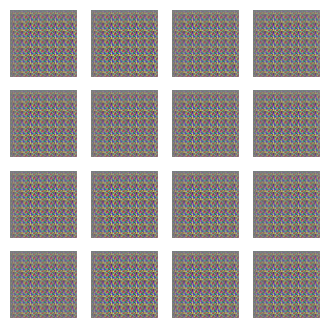

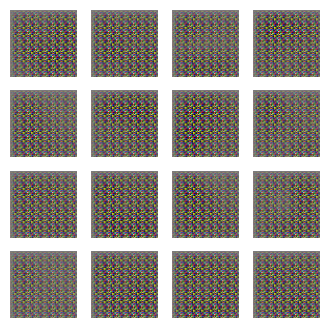

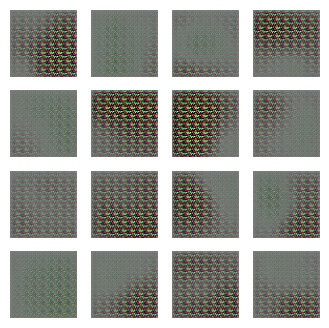

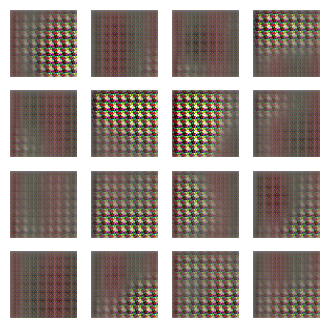

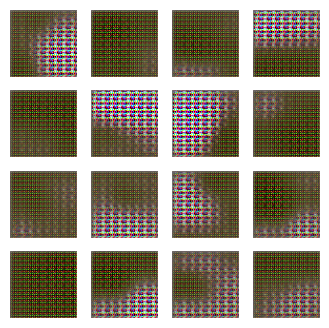

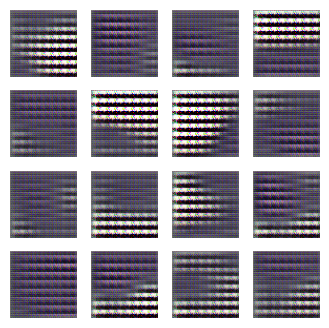

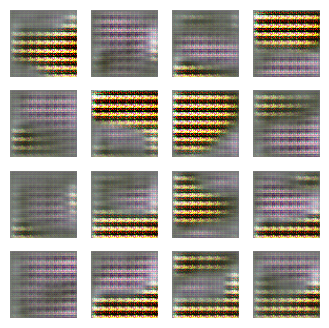

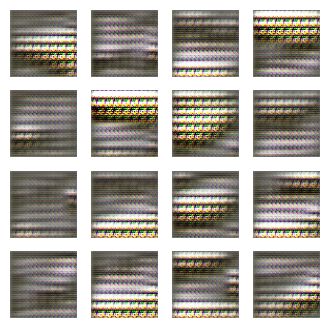

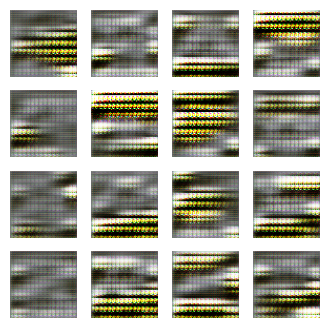

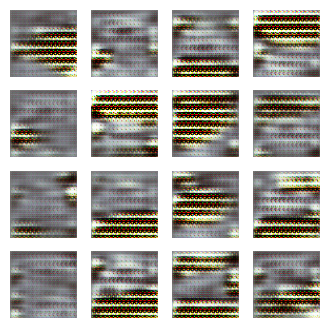

In [6]:
# Step 6: Training Loop
import matplotlib.pyplot as plt

EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Generate sample images after each epoch
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(4,4))
        for i in range(predictions.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype("uint8"))
            plt.axis("off")
        plt.show()

train(dataset, EPOCHS)


In [7]:
# Step 7: Export Sprites
noise = tf.random.normal([25, noise_dim])
generated_images = generator(noise, training=False)

for i, img in enumerate(generated_images):
    plt.imsave(f"sprite_{i}.png", (img * 127.5 + 127.5).numpy().astype("uint8"))


In [9]:
generator.save("pixelart_generator.keras")